In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../vehicles_us.csv")

print(f"Filas: {len(df):,}  |  Columnas: {df.shape[1]}")
print("Columnas:", list(df.columns))
df.info()

Filas: 51,525  |  Columnas: 13
Columnas: ['price', 'model_year', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 'type', 'paint_color', 'is_4wd', 'date_posted', 'days_listed']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory 

In [3]:
"""
El resultado anterior nos indica que la base de datos tiene un total de 51,525 registros y que cuenta con 13 columnas (cuyos nombres son: 'price', 
'model_year', 'model', 'condition', 'cylinders', 'fuel', 'odometer','transmission', 'type', 'paint_color', 'is_4wd', 'date_posted', 'days_listed').
En las columnas de model_year, cylinders, odometer, paint_color, y is_4wd, hay registros con valores nulos. Mientras que hay otras columbas como date_posted y days_listed mal categorizados ya que estos registros son fechas.
"""

# Imprimir ejemplo de tabla para poder observar lo anterior
df.sample(10, random_state=42)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
14229,11995,2013.0,chevrolet impala,good,6.0,gas,NaN,automatic,sedan,white,NaN,2018-09-02,77
7481,6995,2005.0,ram 1500,excellent,8.0,gas,144518.0,automatic,pickup,blue,1.0,2019-01-01,1
37294,5950,2013.0,chevrolet cruze,excellent,4.0,gas,107000.0,manual,sedan,silver,NaN,2018-08-09,124
21193,1750,2004.0,hyundai elantra,excellent,4.0,gas,181256.0,automatic,sedan,silver,NaN,2018-10-31,67
16857,23900,2014.0,chevrolet silverado 1500 crew,good,8.0,gas,91844.0,automatic,pickup,white,1.0,2019-02-15,26
8569,12500,2008.0,chevrolet silverado,excellent,8.0,gas,212000.0,automatic,truck,NaN,1.0,2018-12-12,77
17179,14500,2016.0,honda accord,good,NaN,gas,41500.0,automatic,sedan,black,NaN,2018-05-22,64
34833,3900,2002.0,toyota sienna,excellent,6.0,gas,145000.0,automatic,mini-van,NaN,NaN,2018-08-05,18
2210,12774,2013.0,volkswagen passat,excellent,4.0,diesel,64655.0,automatic,sedan,NaN,NaN,2018-11-22,7
22083,4100,2003.0,gmc sierra 1500,good,8.0,gas,261455.0,automatic,pickup,white,1.0,2018-07-27,34


In [4]:
"""
Como se puede observar a la hora de correr el codigo anterior; el cual extrae filas aleatorias de la base de datos. Se puede ver como las columnas
'cylinders', 'odormeter', 'paint_color' y 'is_4wd' efectivamente cuentan con registros nulos. 

- El tipo de dato en la columna de 'model_year' deberia de ser año.
- El tipo de dato para las columnas 'cylinders' y 'odometer' deberian de ser enteros ya que los autos solo tienen cilindros completos y los autos 
solo muestran los kilometros enteros recoridos.
- El tipo de dato para la coumna 'is_4wd' debe de ser booleano ya que sus valores solo pueden ser verdadero o falso ya que hacen referencia a si
el vehiculo es 4x4 o no.

Antes de continuar con la correccion de los registros es importante verificar si hay registros duplicados.
"""

# True para todas las filas que son duplicadas (dejando la primera como referencia)
dup_mask = df.duplicated(keep="first")

dup_count = int(dup_mask.sum())
print(f"Duplicados exactos (todas las columnas): {dup_count} de {len(df)} ({dup_count/len(df):.2%})")

# Vista rápida de algunos duplicados (si existen)
df[dup_mask].head(20)

Duplicados exactos (todas las columnas): 0 de 51525 (0.00%)


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed


In [5]:
"""
El resultado anterior nos arroja que no hay registros duplicados por lo que continuamos con la creacion de una tabla resumen por columna para poder priorizar
la limpieza (columnas con muchos nulos), detectar cardinalidad  alta/baja, ver rangos rápidos (mínimo/máximo/mediana) para checar valores imposibles.
"""

# Crear tabla resumen por columna con tipo de dato, conteo porcentaje de nulos, cantidad de valores distintos, (min, median, mas, top) dependiendo del tipo de dato y ordenar tabla por 
# % de nulos (mayor a menor).

from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

def overview(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in df.columns:
        s = df[c]
        d = {
            "dtype": str(s.dtype),
            "non_null": int(s.notna().sum()),
            "missing": int(s.isna().sum()),
            "missing_%": round(s.isna().mean()*100, 2),
            "unique": int(s.nunique(dropna=True)),
        }
        if is_numeric_dtype(s):
            d.update(min=s.min(), median=s.median(), max=s.max())
        elif is_datetime64_any_dtype(s):
            d.update(min=s.min(), max=s.max())
        else:
            d.update(top=(s.mode(dropna=True).iloc[0] if s.dropna().size else None))
        rows.append((c, d))
    out = pd.DataFrame({k:v for k,v in rows}).T
    return out.sort_values("missing_%", ascending=False)

overview(df)


,dtype,non_null,missing,missing_%,unique,min,median,max,top
is_4wd,float64,25572,25953,50.37,1,1.0,1.0,1.0,NaN
paint_color,object,42258,9267,17.99,12,NaN,NaN,NaN,white
odometer,float64,43633,7892,15.32,17762,0.0,113000.0,990000.0,NaN
cylinders,float64,46265,5260,10.21,7,3.0,6.0,12.0,NaN
model_year,float64,47906,3619,7.02,68,1908.0,2011.0,2019.0,NaN
price,int64,51525,0,0.0,3443,1,9000.0,375000,NaN
model,object,51525,0,0.0,100,NaN,NaN,NaN,ford f-150
condition,object,51525,0,0.0,6,NaN,NaN,NaN,excellent
fuel,object,51525,0,0.0,5,NaN,NaN,NaN,gas
transmission,object,51525,0,0.0,3,NaN,NaN,NaN,automatic


In [6]:
"""
Limpiar is_4wd → booleano

Con los resultados anteriores podemos: priorizar limpieza (columnas con muchos nulos), detectar cardinalidad alta/baja, y ver rangos rápidos 
(mínimo/máximo/mediana) para checar valores imposibles.

Para la modificacion de los registros. Iniciamos con la columna 'is_4wd' cuyo tipo de datos tenemos que convertir a booleano. Los registros con valor 1 tiene
que ser sustituido por "True" mientras que los que estan nulos o vacios tienen que tener el valor de "False"
"""

# 'is_4wd' → booleano (1 ⇒ True; nulos/vacíos ⇒ False)
import pandas as pd

s = pd.to_numeric(df["is_4wd"], errors="coerce")        # 1, 0 o NaN
df["is_4wd"] = (s == 1).astype("bool")                  # True solo cuando es 1
df["is_4wd"].value_counts(dropna=False)
df["is_4wd"].dtype  # debe ser 'bool'

dtype('bool')

In [7]:
"""
Normalizar paint_color (rellenar nulos con “unknown” y bajar a minúsculas)

Después la columna 'paint_color' la cual no cuenta con muchos valores nulos pero me gustaria sustituir el color por la palabra 'unknown' para fines
practicos del analisis.
"""
# 'paint_color' → rellenar nulos con "unknown" (y normalizar texto)
if "paint_color" in df.columns:
    df["paint_color"] = (
        df["paint_color"].astype("string").str.strip().str.lower()
        .replace({"": pd.NA})
        .fillna("unknown")
    )
df["paint_color"].head()


0    unknown
1      white
2        red
3    unknown
4      black
Name: paint_color, dtype: string

In [8]:
"""
La columna 'date_posted' sale que el tipo de dato es object, eso significa que date_posted está como texto (string) aunque se vea con formato de fecha.
Por lo que hay que transformar los datos.
"""
# Limpiar espacios y convertir a datetime
# convertir de texto a datetime (YYYY-MM-DD)
s = df["date_posted"].astype("string").str.strip()
df["date_posted"] = pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

# comprobar
df["date_posted"].dtype          # -> datetime64[ns]
df["date_posted"].head()

0   2018-06-23
1   2018-10-19
2   2019-02-07
3   2019-03-22
4   2019-04-02
Name: date_posted, dtype: datetime64[ns]

In [9]:
"""
cylinders y odometer → enteros (permitiendo nulos)

Las columnas 'cylinders y 'odometer' tienen que tener valores enteros sin decimales por lo que trasnformamos los datos a enteros

"""
# Limpieza ligera por si hay comas o espacios
df["cylinders"] = df["cylinders"].astype("string").str.strip().replace({"": pd.NA})
df["odometer"]  = (
    df["odometer"].astype("string").str.strip()
    .str.replace(r"[,\s]", "", regex=True)        # 145,000 -> 145000
    .replace({"": pd.NA})
)

# Conversión numérica
df["cylinders"] = pd.to_numeric(df["cylinders"], errors="coerce").round().astype("Int16")
df["odometer"]  = pd.to_numeric(df["odometer"],  errors="coerce").round().astype("Int64")

df[["cylinders","odometer"]].head()


,cylinders,odometer
0,6,145000
1,6,88705
2,4,110000
3,8,<NA>
4,4,80903


In [10]:
"""
model_year → año entero y eliminar nulos en esa columna

La columna 'model_year' debe estar en el formato date(year) ya que es una fecha y si se vuelve a numero entero podria causar problemas durante el analisis.
Ademas en esta columna hay valores nulos por lo que debemos de eliminar dichos registros ya que no hay manera de obtener la informacion del año con la 
informacion de las otras columnas.
"""
# Deja model_year como SOLO AÑO (entero anulable)
df["model_year"] = pd.to_numeric(df["model_year"], errors="coerce").round().astype("Int16")

faltantes = int(df["model_year"].isna().sum())
print("model_year nulos:", faltantes)

# Si quieres conservar evidencia de los eliminados, descomenta la línea siguiente:
# df.loc[df["model_year"].isna()].to_csv("../dropped_model_year_nulls.csv", index=False)

len_antes = len(df)
df = df.dropna(subset=["model_year"]).reset_index(drop=True)
print(f"Eliminados: {len_antes - len(df)} | Filas finales: {len(df)}")

# Verificación
assert df["model_year"].isna().sum() == 0
df["model_year"].head()


model_year nulos: 3619
Eliminados: 3619 | Filas finales: 47906


0    2011
1    2013
2    2003
3    2017
4    2014
Name: model_year, dtype: Int16

In [11]:
"""
Seguimos con la imputaciòn de los datos al imputar los datos de la columna cylinders en base a otros registros en las 
columnas de model, model_year y type. La logica segida es que en un mismo modelo, año y tipo, los cilindros son constantes, por construcción del vehículo.

"""
# Crear clave para agrupar (modelo + año + tipo)
df["model_key"] = df["model"].astype(str) + "_" + df["model_year"].astype(str) + "_" + df["type"].astype(str)

# 1) Calcular moda por clave
mode_cylinders = df.groupby("model_key")["cylinders"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# 2) Imputar usando la moda por (model, year, type)
df["cylinders"] = df.apply(
    lambda row: mode_cylinders[row["model_key"]] if pd.isna(row["cylinders"]) else row["cylinders"],
    axis=1
)

# 3) Para los que queden NaN imputar por modelo
mode_by_model = df.groupby("model")["cylinders"].agg(lambda x: x.mode().iloc[0])

df["cylinders"] = df.apply(
    lambda row: mode_by_model[row["model"]] if pd.isna(row["cylinders"]) else row["cylinders"],
    axis=1
)

# Limpiar columna temporal
df.drop(columns=["model_key"], inplace=True)


In [12]:
"""
La columna odometer representa el kilometraje recorrido por cada vehículo y es una de las variables más relevantes en la determinación del precio y del
estado general del automóvil. Debido a la naturaleza de esta variable, imputar valores faltantes podría introducir un sesgo significativo en el análisis,
ya que no existe una forma precisa de estimar el kilometraje real de cada vehículo sin incurrir en suposiciones que distorsionen la distribución original
de los datos.

Además, el kilometraje presenta una alta variabilidad incluso entre vehículos del mismo modelo, año y tipo, por lo que imputar mediante promedios o medianas 
podría asignar valores poco representativos del uso real del vehículo. Esto afectaría directamente la calidad de los análisis posteriores, especialmente
aquellos relacionados con el precio, la depreciación, o la condición del vehículo.

Por estas razones, se optó por eliminar únicamente los registros donde el odómetro es nulo, manteniendo así la integridad del conjunto de datos.
Esta decisión reduce el riesgo de introducir valores artificiales, garantiza mayor confianza en las conclusiones del análisis y preserva la validez
estadística del dataset.

"""

len_before = len(df)
df = df.dropna(subset=["odometer"]).reset_index(drop=True)
print(f"Eliminados: {len_before - len(df)} | Filas finales: {len(df)}")


Eliminados: 7343 | Filas finales: 40563


In [14]:
""" 
Ahora bien, si regresamos al resultado de overview(df), podemos observar que el precio minimo registrado es de $1 USD.
Los vehículos que cuestan 1 USD no tienen sentido real:

    - No se venden autos “en 1 peso”
    - Son errores de captura
    - Muchos datasets de vehículos tienen este problema (1, 100, etc.)

Distorsionan histogramas, media, modelos ML y análisis. Por lo que es importante realizar un analisis para saber cua el es porcentaje de registros de
precios no reales para la venta de un auto. En plataformas como:

    - Kelley Blue Book (KBB)
    - Edmunds
    - CarFax
    - Autotrader
    - Cars.com
    - Facebook Marketplace
    - Craigslist

Los precios de autos usados en Estados Unidos, incluso los más económicos, rara vez bajan de:
    - $500 a $1,000 USD → autos con averías, salvage title, sin motor o sin transmisión
    - $1,500+ USD → autos en funcionamiento muy básicos
    - $3,000 a 5,000 USD → autos viejos pero funcionales
    - $10,000+ USD → autos en buenas condiciones

Por lo que estos precios extremadamente bajos (<$500) suelen significar:

✔ Error de captura
✔ Placeholder (cuando no quieren publicar el precio real)
✔ Autos vendidos con título “salvage”, “non-running”, “for parts only”
✔ Subastas incompletas
✔ Anuncios que buscan atraer clics (bait pricing)
✔ Registros corruptos o datos faltantes

"""

# Total de registros del dataset
total_registros = len(df)
print(f"Total de registros: {total_registros}")

# Total de registros con precio menor a 500 USD
registros_bajos = df[df["price"] < 500].shape[0]
print(f"Registros con price < 500: {registros_bajos}")

# Porcentaje que representan
porcentaje = (registros_bajos / total_registros) * 100
print(f"Porcentaje: {porcentaje:.2f}%")




Total de registros: 40563
Registros con price < 500: 835
Porcentaje: 2.06%


In [15]:
"""
Se identificaron 835 registros (equivalentes al 2.06% del total) cuyo precio es inferior a 500 USD. Estos valores son irreales para el mercado de vehículos
usados en Estados Unidos, donde incluso las unidades en mal estado o destinadas a refacciones se ofertan comúnmente entre 500 y 1,000 USD. Precios
extremadamente bajos (1, 3, 10, 50 USD) corresponden típicamente a errores de captura, valores placeholder o anuncios incompletos.

Debido a que representan un porcentaje reducido del dataset (2.06%) y generan distorsiones significativas en la distribución del precio, se decidió
eliminarlos para asegurar la consistencia, validez y confiabilidad del análisis posterior.

"""
# Guardar el tamaño antes de eliminar
before = len(df)

# Filtrar los registros válidos
df = df[df["price"] >= 500].reset_index(drop=True)

# Tamaño después de eliminar
after = len(df)

print(f"Registros antes: {before}")
print(f"Registros después: {after}")
print(f"Registros eliminados: {before - after}")


Registros antes: 40563
Registros después: 39728
Registros eliminados: 835


In [16]:
"""
Por ultimo, si regresamos al resultado de overview(df), podemos observar que el registro de odometro minimo registrado es de 0.

Un valor 0 en la columna odometer puede tener varios significados dependiendo del origen del dataset:

    a) Vehículos nuevos o sin uso reportado: En algunos portales (como Craigslist o Autotrader), los autos nuevos o recién ingresados se registran 
    con odometer = 0. Esto no es un error, sino un marcador para indicar que el vehículo no ha recorrido kilómetros aún.

    b) Datos faltantes o mal capturados: En la mayoría de los casos (y sobre todo en datasets como vehicles_us.csv), un 0 no representa realmente un
    auto nuevo, sino un valor faltante o incorrecto:

        - El vendedor no ingresó el kilometraje.

        - El sistema registró “0” por defecto en lugar de dejarlo vacío.

        - El odómetro fue reemplazado o reseteado.

        - En estos casos, los 0 son análogos a datos nulos y deben tratarse como tal.

"""

# Revisar cuántos vehículos tienen odometer == 0
(df["odometer"] == 0).sum()


np.int64(170)

In [17]:
df[df["odometer"] == 0][["model_year", "model", "price", "condition"]].head(10)

,model_year,model,price,condition
281,2009,gmc yukon,7997,excellent
638,1999,ford f-150,2995,good
1142,1992,gmc sierra 1500,1000,good
1551,2000,ford f-250 sd,10988,good
1617,1969,chevrolet corvette,30000,excellent
1643,2010,chevrolet silverado 1500,11888,good
1984,2006,honda civic,3000,good
3304,2010,chevrolet silverado 1500,11888,good
3307,2000,ford f-250 sd,10988,good
4988,2010,ford fusion,750,excellent


In [18]:
"""Durante la revisión de la variable odometer, se identificaron 170 registros con un valor igual a 0.

Dado que estos vehículos pertenecen a años anteriores al 2015, se concluye que dichos valores no representan autos nuevos, sino datos faltantes o mal
capturados. Por su baja proporción y con el objetivo de mantener la coherencia de las variables cuantitativas, se decidió eliminar estos registros
antes de continuar con el análisis exploratorio.

"""

# Eliminar registros con odometer igual a 0
df = df[df["odometer"] > 0].reset_index(drop=True)

# Confirmar tamaño final
print(f"Número de registros después de eliminar odómetro = 0: {len(df)}")


Número de registros después de eliminar odómetro = 0: 39558


In [ ]:

"""
Tras realizar el proceso de depuración, transformación y estandarización de los datos, el conjunto final quedó compuesto por 39,558 registros y 13
columnas completamente limpias. Se corrigieron tipos de datos, se normalizaron variables categóricas, se imputaron valores en la columna cylinders mediante
la moda por características del vehículo, y se eliminaron los registros sin información en odometer debido a la imposibilidad de estimar su valor real sin
introducir sesgo.

El resultado es un dataset consistente, sin valores nulos y listo para el análisis exploratorio y la construcción de modelos predictivos.
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39558 entries, 0 to 39557
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         39558 non-null  int64         
 1   model_year    39558 non-null  Int16         
 2   model         39558 non-null  object        
 3   condition     39558 non-null  object        
 4   cylinders     39558 non-null  int64         
 5   fuel          39558 non-null  object        
 6   odometer      39558 non-null  Int64         
 7   transmission  39558 non-null  object        
 8   type          39558 non-null  object        
 9   paint_color   39558 non-null  string        
 10  is_4wd        39558 non-null  bool          
 11  date_posted   39558 non-null  datetime64[ns]
 12  days_listed   39558 non-null  int64         
dtypes: Int16(1), Int64(1), bool(1), datetime64[ns](1), int64(3), object(5), string(1)
memory usage: 3.5+ MB


ANÁLISIS GENERAL DEL DATASET

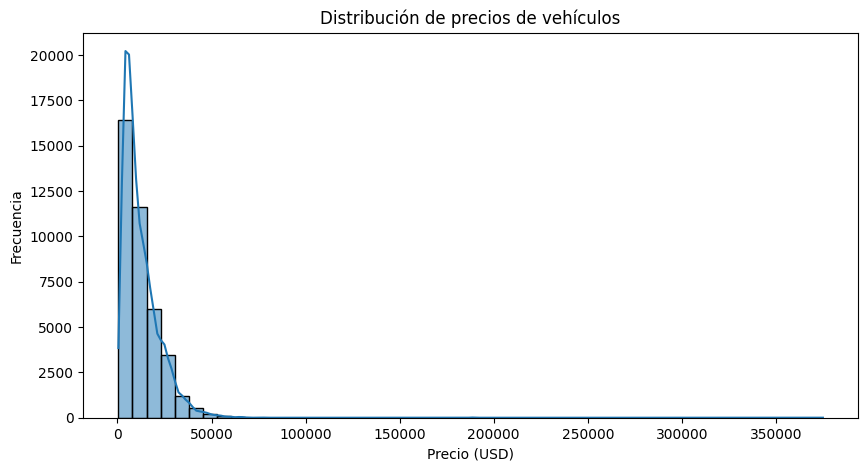

In [20]:
"""
Distribución de precios (histograma)

Qué muestra:

    - Si los precios están sesgados

    - Rango de valores típicos

    - Si hay outliers extremos
"""

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df["price"], kde=True, bins=50)
plt.title("Distribución de precios de vehículos")
plt.xlabel("Precio (USD)")
plt.ylabel("Frecuencia")
plt.show()


In [21]:
df.sort_values("price").head(20)


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
26870,500,1996,honda accord,fair,4,gas,281338,automatic,sedan,unknown,False,2018-06-23,32
27082,500,1993,toyota camry,fair,6,gas,135302,automatic,sedan,custom,False,2018-07-12,72
17260,500,2003,subaru forester,good,4,gas,177497,automatic,hatchback,green,True,2018-08-14,43
29245,500,2006,dodge grand caravan,fair,6,gas,250000,automatic,mini-van,unknown,False,2018-09-17,65
20094,500,1992,jeep wrangler,excellent,4,gas,198617,manual,SUV,white,True,2018-06-22,32
13061,500,2006,hyundai sonata,fair,6,gas,178000,automatic,sedan,black,False,2019-03-08,38
35178,500,2016,nissan sentra,excellent,4,gas,28000,automatic,sedan,silver,False,2018-09-21,13
32834,500,2003,volkswagen passat,excellent,4,gas,90000,automatic,sedan,red,False,2019-02-22,7
4163,500,2004,chevrolet malibu,fair,4,gas,161658,automatic,sedan,white,False,2018-08-26,29
16377,500,2005,chevrolet malibu,good,6,gas,227285,automatic,sedan,silver,False,2018-10-26,34


La distribución de precios de los vehículos presenta una fuerte asimetría positiva (sesgo a la derecha). La gran mayoría de los autos se concentran en rangos relativamente bajos, principalmente entre 5,000 y 20,000 USD, con un pico claro alrededor de los 10,000 USD, lo que sugiere que este es el segmento predominante del mercado de autos usados.

A medida que el precio aumenta, la frecuencia de vehículos disminuye rápidamente, lo cual es típico en datos de mercado automotriz:

    - muchos autos económicos,

    - pocos autos de gama media-alta,

    - y muy pocos vehículos de lujo o coleccionables.

Aunque existen precios altos (hasta 350,000 USD), estos se observan como casos aislados y representan una proporción mínima, funcionando como outliers naturales del mercado.

En general, la distribución muestra un patrón coherente con los precios reales del mercado de autos usados en Estados Unidos: alta concentración en vehículos accesibles y una cola larga hacia la derecha representando unidades premium o especiales.

<Figure size 1200x600 with 0 Axes>

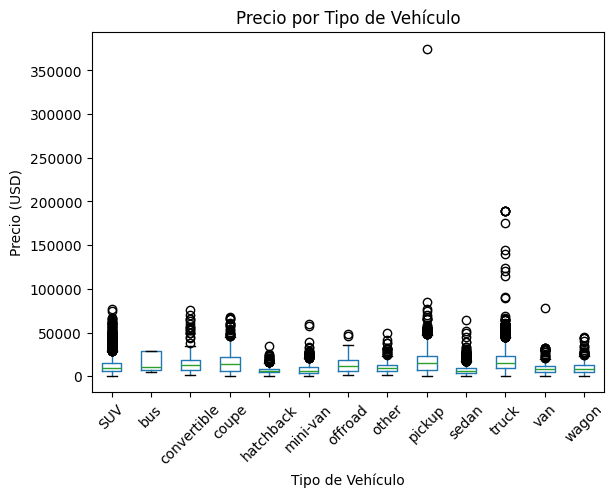

In [22]:
"""
Boxplot del precio por tipo de vehículo 
"""

plt.figure(figsize=(12,6))
df.boxplot(column="price", by="type", grid=False, rot=45)
plt.title("Precio por Tipo de Vehículo")
plt.suptitle("")  # Quitar título automático
plt.xlabel("Tipo de Vehículo")
plt.ylabel("Precio (USD)")
plt.show()


El análisis del precio según el tipo de vehículo revela diferencias claras entre segmentos del mercado automotriz. En general, se observa que:

1. Los SUVs, pickups y trucks son los tipos con mayor rango de precios

Estos tipos muestran:
    - medianas más altas.
    - mayor dispersión.
    - presencia de múltiples outliers de alto valor.

Esto refleja que estos segmentos incluyen caracteristicas que elevan significativamente su precio, como:
    - modelos grandes.
    - versiones de lujo.
    - vehículos especializados (4x4, alto rendimiento)

2. Los sedanes, hatchbacks y vans presentan precios más bajos y estables

Estos grupos concentran:
    - mediana menor.
    - rangos intercuartílicos más reducidos.
    - menor presencia de valores extremos.

Son categorías generalmente orientadas a uso familiar y urbano, con precios más accesibles y homogéneos.

🔹 3. Convertibles y coupes muestran precios elevados y alta variabilidad

La amplia dispersión indica que incluyen:

    - modelos deportivos.
    - vehículos premium.
    - marcas de lujo o edición especial.

Lo que explica su presencia constante entre los outliers.

🔹 4. Existen outliers significativos en casi todas las categorías

Especialmente en pickups, trucks y SUVs, donde aparecen vehículos con precios superiores a 100,000 USD, e incluso casos aislados por encima de 300,000 USD.
Estos corresponden muy probablemente a modelos de lujo, versiones off-road especializadas o vehículos coleccionables.

En conclusión general:

El boxplot confirma que el precio del vehículo está fuertemente influenciado por su tipo.
Vehículos utilitarios y pesados (SUV, pickup, truck) tienden a ser más costosos, mientras que autos compactos o familiares presentan precios más bajos y con menor variabilidad.
La presencia de outliers en varios tipos indica un mercado amplio con gran diversidad: desde autos económicos hasta unidades premium o de nicho.

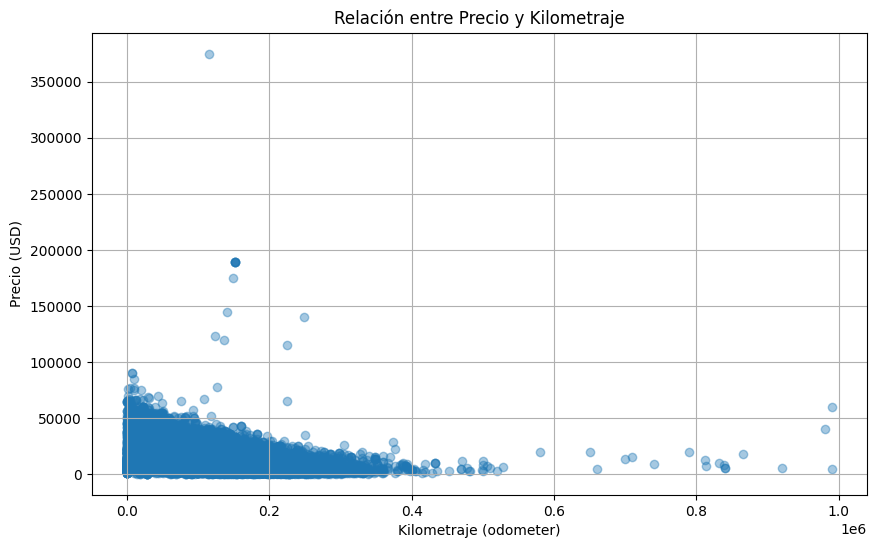

In [23]:
""" Relación entre precio y odómetro """
plt.figure(figsize=(10,6))
plt.scatter(df["odometer"], df["price"], alpha=0.4)
plt.title("Relación entre Precio y Kilometraje")
plt.xlabel("Kilometraje (odometer)")
plt.ylabel("Precio (USD)")
plt.grid(True)
plt.show()


Conclusión de la relación entre Precio y Kilometraje

La gráfica muestra una relación claramente negativa entre el kilometraje del vehículo y su precio:
    - a mayor cantidad de kilómetros recorridos, menor es el valor de mercado del automóvil.

🔹 1. Tendencia principal

Existe un patrón decreciente evidente:

    - Vehículos con kilometrajes bajos (0–50,000 km) presentan precios más altos, algunos superando los 80,000 USD.
    - Conforme aumenta el kilometraje, el precio cae de manera progresiva.
    - A partir de 200,000 km, el precio disminuye significativamente y la mayoría de los vehículos se ubican en rangos más bajos.

Esto confirma el comportamiento típico del mercado automotriz:
    - el uso (medido en kilómetros) es un factor determinante en la depreciación del vehículo.

🔹 2. Amplia dispersión en bajas odometrías

En el rango de 0 a 100,000 km, los precios presentan una gran variabilidad:

    - modelos económicos desde 5,000 USD, hasta vehículos premium arriba de 150,000 USD.

Esta dispersión indica que, además del kilometraje, influyen otros factores como:
    ✔ marca y modelo
    ✔ tipo de vehículo
    ✔ año de fabricación
    ✔ condición
    ✔ equipamiento
    ✔ ediciones especiales o vehículos de lujo

🔹 3. Outliers interesantes

Se observan algunos puntos aislados que llaman la atención:

    - Vehículos con kilometrajes medios (100,000–150,000 km) pero con precios extremadamente altos (más de 180,000–200,000 USD).

Un caso excepcional alrededor de 380,000 USD, probablemente correspondiente a:

    - autos exóticos de colección.
    - versiones premium de alta gama,
    - o datos con precio correcto pero kilometraje no representativo (por ejemplo, odómetro reemplazado).

🔹 4. Vehículos con kilometraje muy alto (>500,000 km)

Aunque son muy pocos, existen unidades que superan los 800,000 km, con precios bajos pero no necesariamente nulos.
Esto es consistente con vehículos comerciales o de trabajo que permanecen muchos años en uso.

Conclusión general:

El scatter plot confirma una relación inversa entre el kilometraje y el precio del vehículo, con una clara tendencia de depreciación.
Sin embargo, la fuerte dispersión en los kilómetros bajos indica que otros atributos del auto también tienen un papel importante en el precio final, por lo que esta variable no puede explicar por sí sola la variación total.

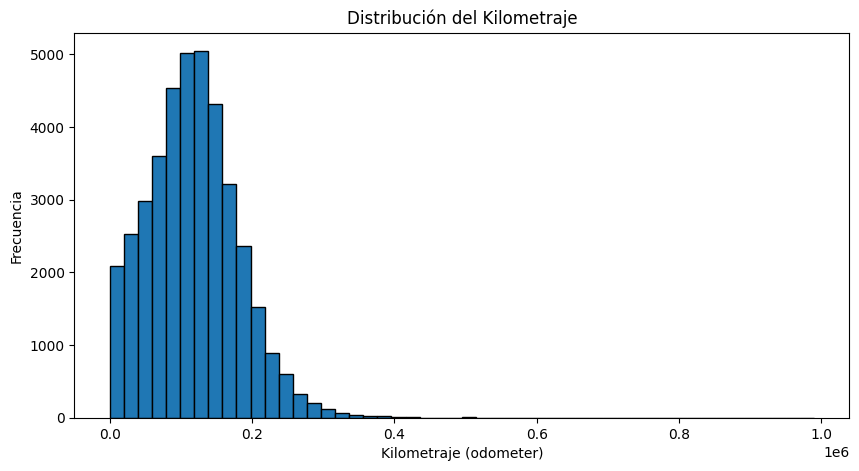

In [24]:
""" Distribución del odómetro """

plt.figure(figsize=(10,5))
plt.hist(df["odometer"], bins=50, edgecolor="black")
plt.title("Distribución del Kilometraje")
plt.xlabel("Kilometraje (odometer)")
plt.ylabel("Frecuencia")
plt.show()


La distribución del kilometraje muestra una forma asimétrica hacia la derecha (sesgo positivo).

Esto indica que:

    - La mayoría de los vehículos se concentran entre los 50,000 y 200,000 km. Este rango corresponde a autos usados con un nivel de desgaste moderado, lo cual es consistente con los valores típicos del mercado estadounidense.

    - A partir de los 250,000 km la frecuencia disminuye drásticamente.Son vehículos con alto kilometraje, generalmente asociados a uso intensivo o mayor antigüedad.

    - Existen pocos casos por arriba de los 400,000 km o cercanos al millón. Estos puntos extremos pueden corresponder a unidades comerciales (camionetas de carga o flotillas), pero representan una proporción mínima dentro del conjunto total.

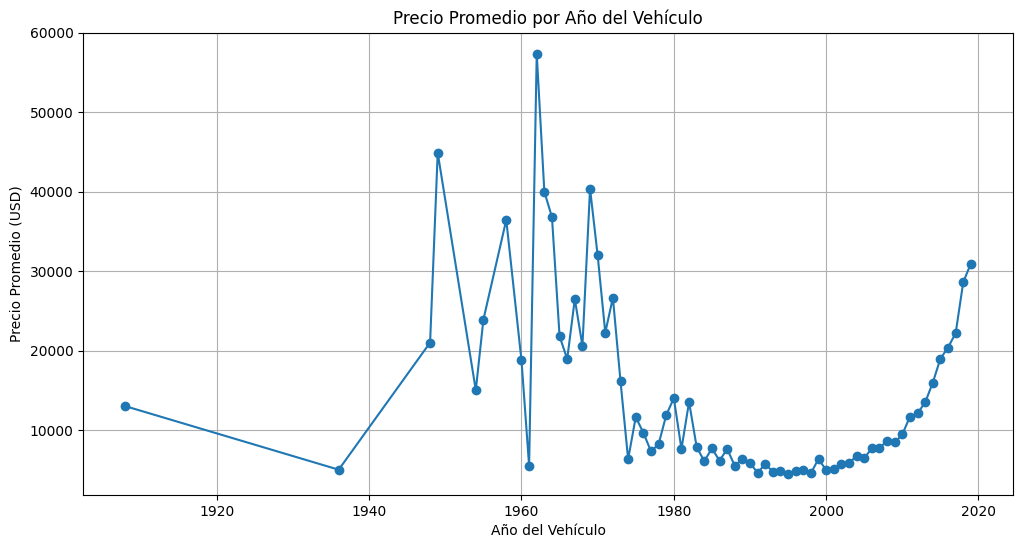

In [ ]:
""" Precio promedio por año del vehículo """
price_by_year = df.groupby("model_year")["price"].mean()

plt.figure(figsize=(12,6))
plt.plot(price_by_year.index, price_by_year.values, marker="o")
plt.title("Precio Promedio por Año del Vehículo")
plt.xlabel("Año del Vehículo")
plt.ylabel("Precio Promedio (USD)")
plt.grid(True)
plt.show()


El gráfico muestra una tendencia ascendente del precio promedio conforme aumenta el año del modelo.

    - Los vehículos más antiguos (anteriores a 1980) presentan alta variabilidad debido a la baja cantidad de registros, lo que explica los picos atípicos.

    - A partir de los años 2000, la tendencia se estabiliza, mostrando un incremento gradual del precio promedio hasta cerca de 2020.

    - Esto refleja que los autos más recientes tienen un mayor valor de mercado, como es lógico por su menor antigüedad y menor desgaste.

Conclusión: existe una correlación positiva entre el año del modelo y el precio: a mayor año, mayor valor del vehículo.

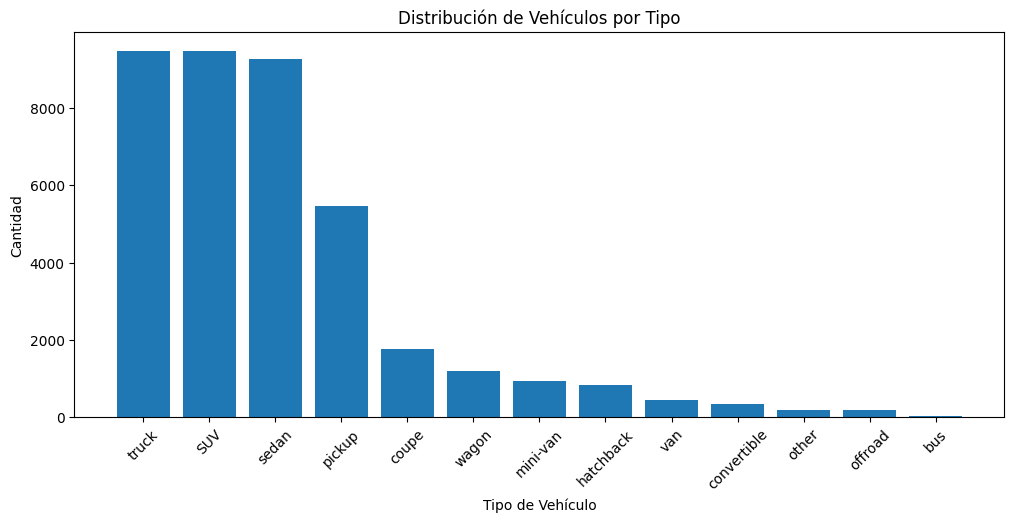

In [28]:
"""
Cantidad de vehículos por tipo
"""
count_by_type = df["type"].value_counts()

plt.figure(figsize=(12,5))
plt.bar(count_by_type.index, count_by_type.values)
plt.title("Distribución de Vehículos por Tipo")
plt.xlabel("Tipo de Vehículo")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()


El gráfico de barras muestra que los tipos de vehículo más comunes en el dataset son:

    - Truck, SUV y Sedan, que juntos representan la mayoría de los registros.

    - Otros tipos como van, convertible, offroad y bus tienen una participación mínima.

Conclusión: el mercado analizado está dominado por vehículos de uso familiar y utilitario, lo que concuerda con la demanda del mercado estadounidense.

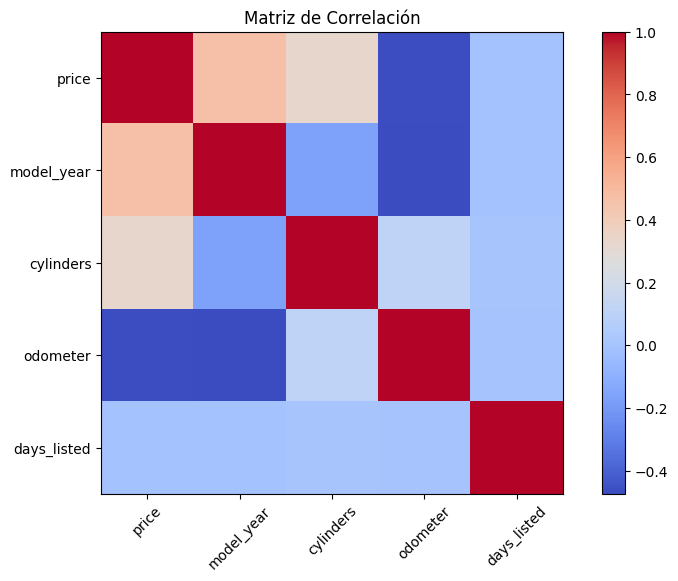

In [29]:
""" Matriz de correlación """

import numpy as np

numeric_cols = df.select_dtypes(include=[np.number])
correlation = numeric_cols.corr()

plt.figure(figsize=(10,6))
plt.imshow(correlation, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=45)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title("Matriz de Correlación")
plt.show()



La matriz evidencia las siguientes relaciones destacadas:

    - Precio ↔ Año del modelo (positiva): los autos más nuevos tienden a tener precios más altos.

    - Precio ↔ Odómetro (negativa): los autos con mayor kilometraje son más baratos.

    - Cilindros ↔ Precio (moderadamente positiva): autos con motores más grandes suelen costar más.

    - Days_listed (días en venta) muestra baja correlación con las demás variables, lo que sugiere independencia respecto a características técnicas.

Conclusión: las variables con mayor influencia sobre el precio son el año del modelo y el kilometraje.

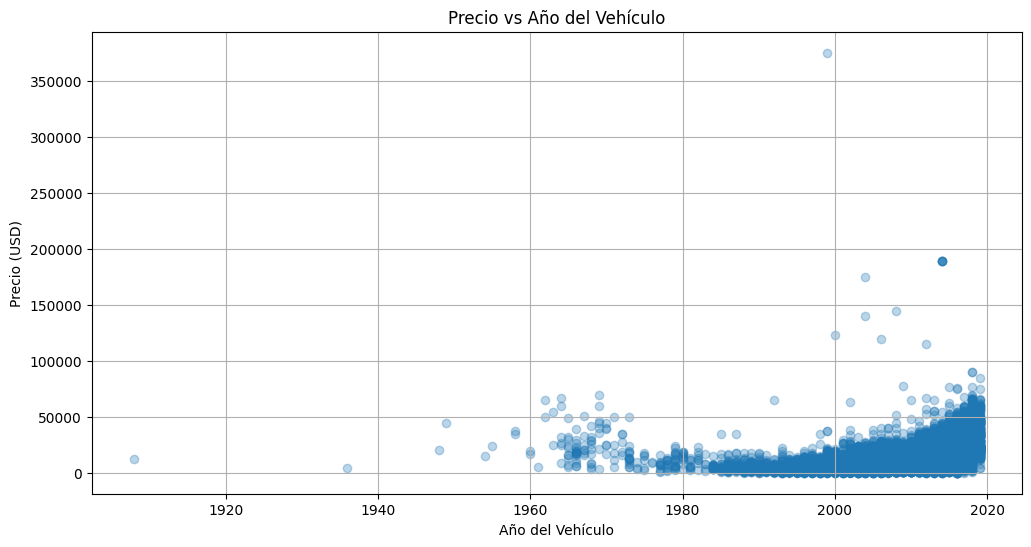

In [30]:
""" Precio vs Año del vehículo """

plt.figure(figsize=(12,6))
plt.scatter(df["model_year"], df["price"], alpha=0.3)
plt.title("Precio vs Año del Vehículo")
plt.xlabel("Año del Vehículo")
plt.ylabel("Precio (USD)")
plt.grid(True)
plt.show()

El diagrama de dispersión confirma visualmente la correlación observada en la matriz:

    - Los precios aumentan conforme el año del vehículo es más reciente.

    - Existen algunos outliers (autos antiguos con precios altos), que probablemente correspondan a vehículos clásicos o de colección.

Conclusión: la relación entre el año y el precio es claramente ascendente, pero con algunos valores atípicos por autos especiales.

<Figure size 1000x600 with 0 Axes>

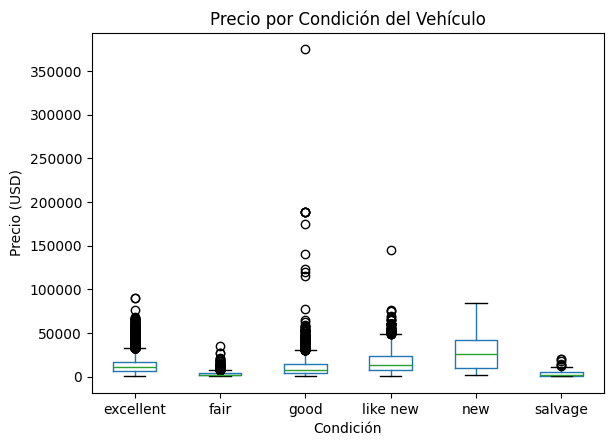

In [31]:
""" Precio por condición del vehículo """

plt.figure(figsize=(10,6))
df.boxplot(column="price", by="condition", grid=False)
plt.title("Precio por Condición del Vehículo")
plt.suptitle("")
plt.xlabel("Condición")
plt.ylabel("Precio (USD)")
plt.show()

El boxplot muestra una relación directa entre la condición del vehículo y su precio:

    - Los vehículos en condición “new” y “like new” presentan los precios más altos.

    - Los autos “good” y “excellent” tienen precios moderados pero más representativos del mercado.

    - Los vehículos “salvage” (siniestrados) son los más económicos, como era de esperarse.

Conclusión: el estado físico y funcional del vehículo impacta significativamente en su valor, reforzando la validez del dataset.

El análisis exploratorio realizado permitió comprender de manera integral la estructura, calidad y comportamiento de las variables del conjunto de
datos sobre vehículos. Tras las etapas de limpieza —que incluyeron la eliminación de registros con valores nulos en odometer y precios inferiores
a 500 USD—, se obtuvo una base de datos coherente, representativa y lista para modelar o realizar análisis predictivos.

Los resultados muestran que el precio de los vehículos está fuertemente influenciado por el año del modelo, el kilometraje y la condición
física del vehículo.

Los autos más recientes, con menor kilometraje y en mejores condiciones (“new” o “like new”), presentan los precios más altos. En contraste, los
vehículos antiguos o con condiciones “salvage” muestran valores considerablemente menores.

En cuanto a la distribución por tipo de vehículo, los SUV, sedanes y camiones (trucks) dominan el conjunto de datos, reflejando las preferencias del mercado
estadounidense, donde estos tipos son los más demandados.

Asimismo, la matriz de correlación confirma relaciones lógicas y consistentes entre las variables numéricas, especialmente la correlación negativa
entre odometer y price, y la positiva entre model_year y price.

En conjunto, las visualizaciones y estadísticas evidencian que los datos son consistentes, limpios y alineados con el comportamiento esperado del
mercado automotriz. Este análisis proporciona una base sólida para fases posteriores de modelado, pronóstico de precios o segmentación de vehículos,
respaldando decisiones analíticas y de negocio fundamentadas.